<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session10/TinyImageNet/EVA7_AssignmentS10_ObjectLocalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 10 - EVA7 - Object Localization
## Submission by Abhinav Pujahari (abhinavpujahari@gmail.com)

Goals - 
1. Train ResNet-18 on Tiny Image dataset
2. Apply augmenttions using Albumentations 
3. Target >50% testing/validation accuracy in 50 Epochs



## Install & Import Dependencies

In [1]:
## Install Dependencies
!pip install albumentations==0.4.6
!pip install torchsummary
!pip install pytorch-ignite

     |████████████████████████████████| 117 kB 7.9 MB/s 
     |████████████████████████████████| 948 kB 37.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=33910626c73a79acf0a92b5b7fa3b3ae2c91175776499eb8754a7c6d77b3a65e
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 240 kB 6.7 MB/s 


## Clone & Import Deep Learning Utils Repo

In [2]:
## Clone Deep Learning Utils Repo
!git clone https://github.com/a-pujahari/Torch_CV_Utils.git

Cloning into 'Torch_CV_Utils'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 193 (delta 114), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 47.82 KiB | 9.56 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [3]:
from Torch_CV_Utils import main
from Torch_CV_Utils.utils import data_handling, train, test, gradcam, helpers, augmentation
from Torch_CV_Utils.models import resnet, resnet18
from pprint import pprint
import os

## Import Configuration

In [4]:
config_file_path = "/content/Torch_CV_Utils/config/config_S10.yaml"

config = helpers.load_config_variables(config_file_path)
pprint(config)

 Loading config ..
 Config succesfully loaded 
{'L2_penalty': 1e-05,
 'coarseDropoutProb': 0.5,
 'grayscaleProb': 0.15,
 'horizontalFlipProb': 0.2,
 'maxHeight': 32,
 'maxHoles': 1,
 'maxWidth': 32,
 'minHeight': 32,
 'minHoles': 1,
 'minWidth': 32,
 'momentum_val': 0.9,
 'oneCycle_pct_start': 0.2,
 'padHeightWidth': 70,
 'randomCropProb': 1,
 'randomCropSize': 64,
 'standard_lr': 0.01}


## Perform GPU Check; Create "Device"

In [5]:
device, cuda = helpers.gpu_check(seed_value = 1)
pprint(device)

CUDA is available
device(type='cuda')


## Download Dataset, Create Data Loaders

In [6]:
# Retrieve tinyimagenet data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
  
# Unzip raw zip file
!unzip -qq 'tiny-imagenet-200.zip'

# Define main data directory
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

val_img_dir = data_handling.prep_tinyimagenet(VALID_DIR)

## Define Imagenet mean and std
tinyimagenet_mean = [0.485, 0.456, 0.406]
tinyimagenet_std = [0.229, 0.224, 0.225]

trainset, testset = data_handling.create_tinyimagenet_datasets(TRAIN_DIR, val_img_dir, tinyimagenet_mean, tinyimagenet_std, config, augment_func = "albumentation_augmentation_S10")

trainloader, testloader = data_handling.return_dataloaders(trainset, testset, cuda)


--2021-12-13 13:17:04--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  5.47MB/s    in 49s     

2021-12-13 13:17:54 (4.80 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model Summary

In [10]:
from torchsummary import summary
from Torch_CV_Utils.models import resnet18
model = resnet18.ResNet18().to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

## Trigger Training

In [11]:
train_acc, train_losses, test_acc, test_losses, lrs = main.trigger_training(model, device, trainloader, testloader, config, optimizer_name = "Adam", scheduler_name = "OneCycle", criterion_name = "CrossEntropyLoss", lambda_l1 = 0, epochs = 50)

EPOCH: 1


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=4.360131740570068 Batch_id=781 LR=0.00063 Accuracy=8.66: 100%|██████████| 782/782 [03:55<00:00,  3.32it/s]



Test set: Average loss: 0.0323, Accuracy: 1192/10000 (11.92%)

EPOCH: 2


Loss=3.966559648513794 Batch_id=781 LR=0.00132 Accuracy=17.36: 100%|██████████| 782/782 [03:55<00:00,  3.32it/s]



Test set: Average loss: 0.0305, Accuracy: 1575/10000 (15.75%)

EPOCH: 3


Loss=3.2703680992126465 Batch_id=781 LR=0.00238 Accuracy=22.75: 100%|██████████| 782/782 [03:55<00:00,  3.32it/s]



Test set: Average loss: 0.0276, Accuracy: 2253/10000 (22.53%)

EPOCH: 4


Loss=2.938666820526123 Batch_id=781 LR=0.00372 Accuracy=27.96: 100%|██████████| 782/782 [03:55<00:00,  3.32it/s]



Test set: Average loss: 0.0265, Accuracy: 2502/10000 (25.02%)

EPOCH: 5


Loss=3.245748519897461 Batch_id=781 LR=0.00520 Accuracy=31.93: 100%|██████████| 782/782 [03:55<00:00,  3.32it/s]



Test set: Average loss: 0.0253, Accuracy: 2845/10000 (28.45%)

EPOCH: 6


Loss=2.4488039016723633 Batch_id=781 LR=0.00668 Accuracy=34.30: 100%|██████████| 782/782 [03:55<00:00,  3.32it/s]



Test set: Average loss: 0.0213, Accuracy: 3616/10000 (36.16%)

EPOCH: 7


Loss=2.6887829303741455 Batch_id=781 LR=0.00802 Accuracy=36.28: 100%|██████████| 782/782 [03:55<00:00,  3.32it/s]



Test set: Average loss: 0.0221, Accuracy: 3540/10000 (35.40%)

EPOCH: 8


Loss=2.610520362854004 Batch_id=781 LR=0.00908 Accuracy=37.69: 100%|██████████| 782/782 [03:56<00:00,  3.31it/s]



Test set: Average loss: 0.0210, Accuracy: 3717/10000 (37.17%)

EPOCH: 9


Loss=3.490727424621582 Batch_id=781 LR=0.00977 Accuracy=39.45: 100%|██████████| 782/782 [03:55<00:00,  3.32it/s]



Test set: Average loss: 0.0234, Accuracy: 3340/10000 (33.40%)

EPOCH: 10


Loss=2.5882210731506348 Batch_id=781 LR=0.01000 Accuracy=40.73: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0230, Accuracy: 3432/10000 (34.32%)

EPOCH: 11


Loss=2.499462842941284 Batch_id=781 LR=0.00998 Accuracy=42.42: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0199, Accuracy: 3982/10000 (39.82%)

EPOCH: 12


Loss=2.284359931945801 Batch_id=781 LR=0.00994 Accuracy=43.53: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0221, Accuracy: 3663/10000 (36.63%)

EPOCH: 13


Loss=2.561221122741699 Batch_id=781 LR=0.00986 Accuracy=44.59: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0189, Accuracy: 4286/10000 (42.86%)

EPOCH: 14


Loss=1.8057279586791992 Batch_id=781 LR=0.00976 Accuracy=45.80: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0218, Accuracy: 3679/10000 (36.79%)

EPOCH: 15


Loss=2.2930963039398193 Batch_id=781 LR=0.00962 Accuracy=46.95: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0180, Accuracy: 4531/10000 (45.31%)

EPOCH: 16


Loss=2.3256325721740723 Batch_id=781 LR=0.00945 Accuracy=47.60: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0183, Accuracy: 4469/10000 (44.69%)

EPOCH: 17


Loss=2.444504737854004 Batch_id=781 LR=0.00926 Accuracy=48.34: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0186, Accuracy: 4338/10000 (43.38%)

EPOCH: 18


Loss=1.9559379816055298 Batch_id=781 LR=0.00904 Accuracy=49.21: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0176, Accuracy: 4663/10000 (46.63%)

EPOCH: 19


Loss=2.192225933074951 Batch_id=781 LR=0.00880 Accuracy=49.85: 100%|██████████| 782/782 [03:56<00:00,  3.31it/s]



Test set: Average loss: 0.0180, Accuracy: 4603/10000 (46.03%)

EPOCH: 20


Loss=1.9672716856002808 Batch_id=781 LR=0.00854 Accuracy=50.78: 100%|██████████| 782/782 [03:56<00:00,  3.31it/s]



Test set: Average loss: 0.0169, Accuracy: 4826/10000 (48.26%)

EPOCH: 21


Loss=3.1198432445526123 Batch_id=781 LR=0.00825 Accuracy=51.60: 100%|██████████| 782/782 [03:56<00:00,  3.31it/s]



Test set: Average loss: 0.0170, Accuracy: 4863/10000 (48.63%)

EPOCH: 22


Loss=1.8129993677139282 Batch_id=781 LR=0.00794 Accuracy=52.21: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0162, Accuracy: 5047/10000 (50.47%)

EPOCH: 23


Loss=2.443483591079712 Batch_id=781 LR=0.00761 Accuracy=53.02: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0171, Accuracy: 4887/10000 (48.87%)

EPOCH: 24


Loss=2.1436767578125 Batch_id=781 LR=0.00727 Accuracy=53.73: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0168, Accuracy: 4923/10000 (49.23%)

EPOCH: 25


Loss=2.4719505310058594 Batch_id=781 LR=0.00691 Accuracy=54.66: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0160, Accuracy: 5161/10000 (51.61%)

EPOCH: 26


Loss=2.347618579864502 Batch_id=781 LR=0.00654 Accuracy=55.27: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0156, Accuracy: 5269/10000 (52.69%)

EPOCH: 27


Loss=1.9380525350570679 Batch_id=781 LR=0.00617 Accuracy=56.39: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0175, Accuracy: 4821/10000 (48.21%)

EPOCH: 28


Loss=2.0798683166503906 Batch_id=781 LR=0.00578 Accuracy=57.46: 100%|██████████| 782/782 [03:56<00:00,  3.31it/s]



Test set: Average loss: 0.0155, Accuracy: 5271/10000 (52.71%)

EPOCH: 29


Loss=1.455937147140503 Batch_id=781 LR=0.00539 Accuracy=58.29: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0156, Accuracy: 5318/10000 (53.18%)

EPOCH: 30


Loss=2.199561595916748 Batch_id=781 LR=0.00500 Accuracy=59.27: 100%|██████████| 782/782 [03:56<00:00,  3.31it/s]



Test set: Average loss: 0.0153, Accuracy: 5363/10000 (53.63%)

EPOCH: 31


Loss=1.7697597742080688 Batch_id=781 LR=0.00461 Accuracy=60.49: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0157, Accuracy: 5295/10000 (52.95%)

EPOCH: 32


Loss=1.3265361785888672 Batch_id=781 LR=0.00422 Accuracy=61.34: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0149, Accuracy: 5512/10000 (55.12%)

EPOCH: 33


Loss=1.8961478471755981 Batch_id=781 LR=0.00383 Accuracy=62.82: 100%|██████████| 782/782 [03:56<00:00,  3.31it/s]



Test set: Average loss: 0.0145, Accuracy: 5599/10000 (55.99%)

EPOCH: 34


Loss=1.7255693674087524 Batch_id=781 LR=0.00345 Accuracy=63.90: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0147, Accuracy: 5642/10000 (56.42%)

EPOCH: 35


Loss=1.979748249053955 Batch_id=781 LR=0.00309 Accuracy=65.27: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0145, Accuracy: 5680/10000 (56.80%)

EPOCH: 36


Loss=1.3266483545303345 Batch_id=781 LR=0.00273 Accuracy=66.42: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0144, Accuracy: 5755/10000 (57.55%)

EPOCH: 37


Loss=1.6970889568328857 Batch_id=781 LR=0.00239 Accuracy=67.82: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0141, Accuracy: 5756/10000 (57.56%)

EPOCH: 38


Loss=1.289254903793335 Batch_id=781 LR=0.00206 Accuracy=69.56: 100%|██████████| 782/782 [03:57<00:00,  3.30it/s]



Test set: Average loss: 0.0142, Accuracy: 5829/10000 (58.29%)

EPOCH: 39


Loss=0.9036016464233398 Batch_id=781 LR=0.00175 Accuracy=70.56: 100%|██████████| 782/782 [03:57<00:00,  3.30it/s]



Test set: Average loss: 0.0139, Accuracy: 5877/10000 (58.77%)

EPOCH: 40


Loss=1.1738958358764648 Batch_id=781 LR=0.00146 Accuracy=72.16: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0141, Accuracy: 5877/10000 (58.77%)

EPOCH: 41


Loss=1.4308476448059082 Batch_id=781 LR=0.00120 Accuracy=73.66: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0141, Accuracy: 5971/10000 (59.71%)

EPOCH: 42


Loss=0.6316440105438232 Batch_id=781 LR=0.00095 Accuracy=74.98: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0142, Accuracy: 5944/10000 (59.44%)

EPOCH: 43


Loss=0.6308168172836304 Batch_id=781 LR=0.00074 Accuracy=76.13: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0143, Accuracy: 5977/10000 (59.77%)

EPOCH: 44


Loss=1.3508305549621582 Batch_id=781 LR=0.00054 Accuracy=77.46: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0142, Accuracy: 5997/10000 (59.97%)

EPOCH: 45


Loss=0.6405795812606812 Batch_id=781 LR=0.00038 Accuracy=78.37: 100%|██████████| 782/782 [03:57<00:00,  3.30it/s]



Test set: Average loss: 0.0141, Accuracy: 6032/10000 (60.32%)

EPOCH: 46


Loss=0.8885684013366699 Batch_id=781 LR=0.00024 Accuracy=79.33: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0142, Accuracy: 6063/10000 (60.63%)

EPOCH: 47


Loss=0.9510505795478821 Batch_id=781 LR=0.00014 Accuracy=80.00: 100%|██████████| 782/782 [03:57<00:00,  3.30it/s]



Test set: Average loss: 0.0143, Accuracy: 6024/10000 (60.24%)

EPOCH: 48


Loss=0.9573735594749451 Batch_id=781 LR=0.00006 Accuracy=80.38: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0142, Accuracy: 6056/10000 (60.56%)

EPOCH: 49


Loss=0.5400015115737915 Batch_id=781 LR=0.00002 Accuracy=80.84: 100%|██████████| 782/782 [03:57<00:00,  3.30it/s]



Test set: Average loss: 0.0142, Accuracy: 6064/10000 (60.64%)

EPOCH: 50


Loss=0.6305838227272034 Batch_id=781 LR=0.00000 Accuracy=80.89: 100%|██████████| 782/782 [03:56<00:00,  3.30it/s]



Test set: Average loss: 0.0141, Accuracy: 6065/10000 (60.65%)



## Plot Metrics

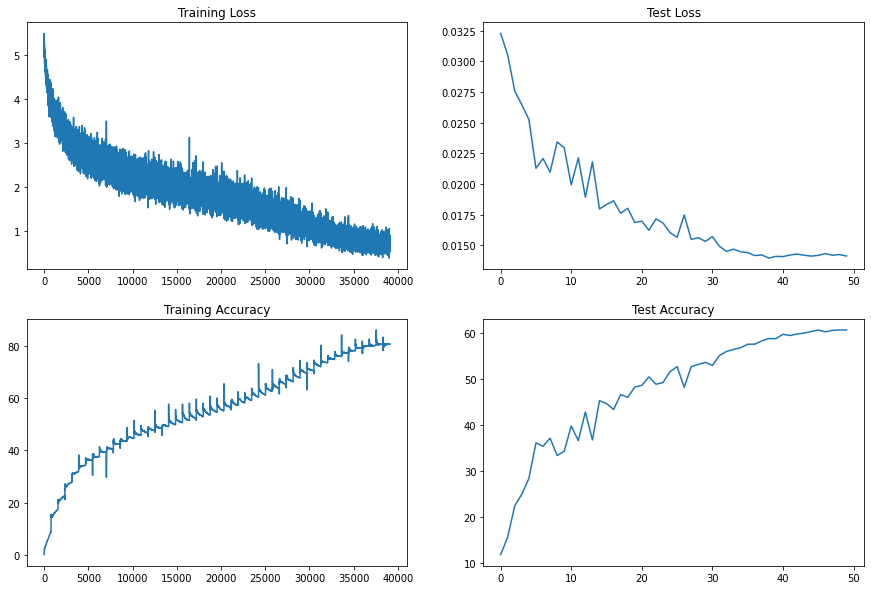

In [12]:
helpers.plot_metrics(train_acc, train_losses, test_acc, test_losses)

## Misclassified Images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Total wrong predictions are 3935


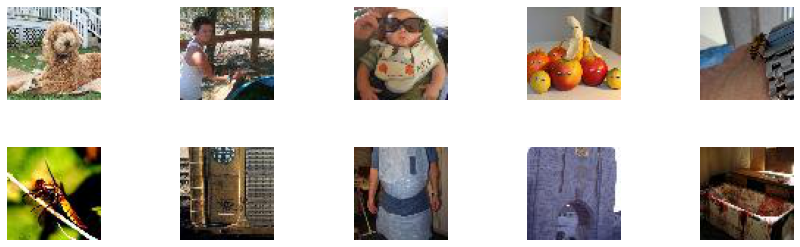

In [28]:
from Torch_CV_Utils.utils import helpers
misclassified_images = helpers.wrong_predictions(model, testloader, device)
plot_misclassified(misclassified_images, tinyimagenet_mean, tinyimagenet_std, 10)

## Gradcam

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Generating Grad-CAM @layer4


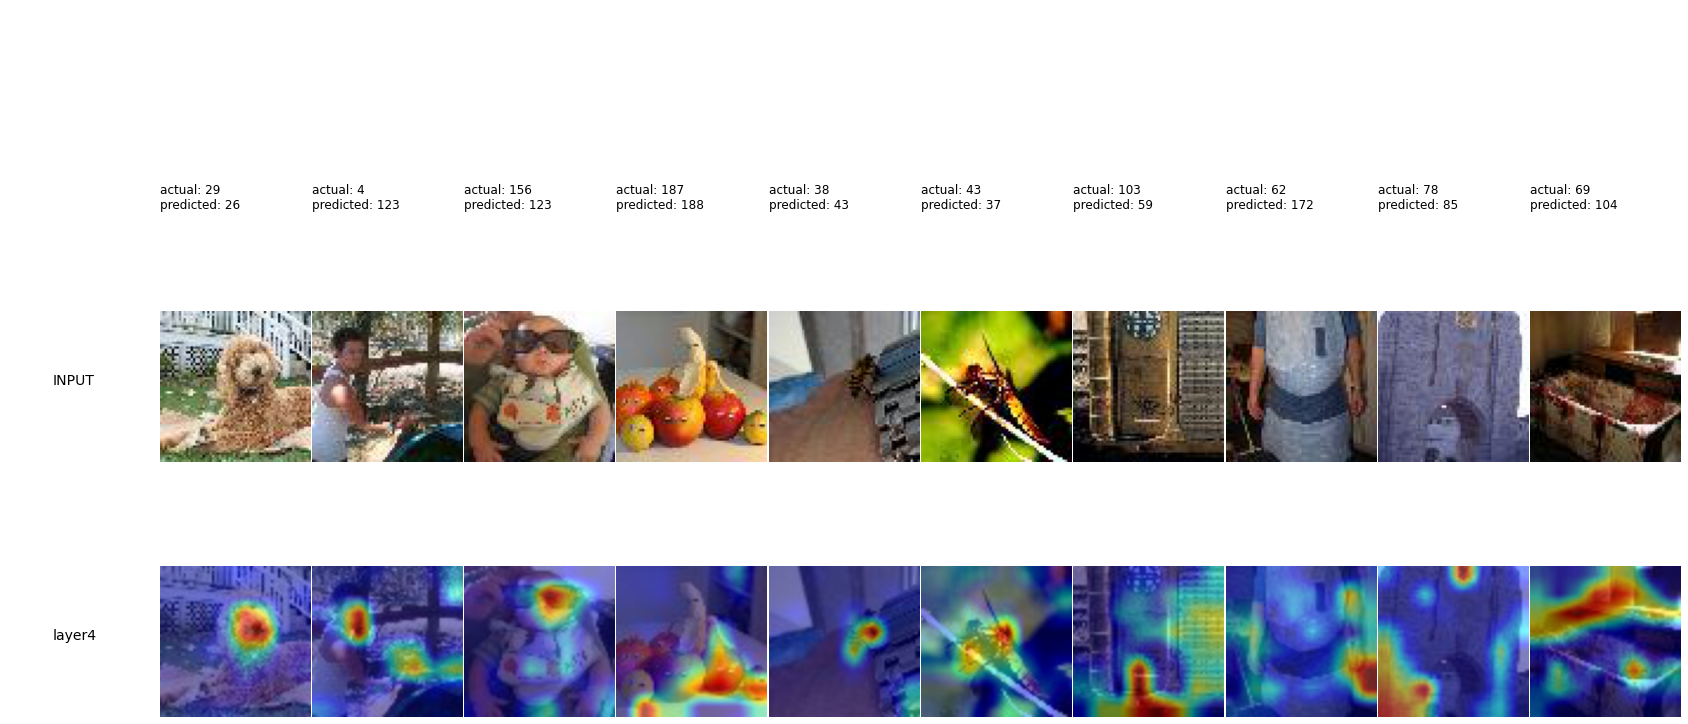

In [43]:
target_layers = ["layer4"]
classes_1 = list(range(0,199))
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(misclassified_images[:10], model, target_layers, device)
gradcam.plot_gradcam(gradcam_output, target_layers, classes_1, (3, 64, 64),predicted_classes, misclassified_images[:10], tinyimagenet_mean, tinyimagenet_std)